In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_fscore_support
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

sns.set(context="notebook")
plt.rcParams["figure.figsize"] = (6.5, 4.0)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42

In [26]:
url = "https://raw.githubusercontent.com/cassiusf/datasets/main/customers_data.csv"
df = pd.read_csv(url)

df.columns = df.columns.str.strip().str.upper().str.replace(r"\s+", "_", regex=True)
df.columns = [c.replace("DELICASSEN", "DELICATESSEN") for c in df.columns]

print("shape:", df.shape)
df.head()

shape: (440, 8)


,CHANNEL,REGION,FRESH,MILK,GROCERY,FROZEN,DETERGENTS_PAPER,DELICATESSEN
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [27]:
# checar tipos e ausentes
print(df.info())
print("\nvalores ausentes por coluna:\n", df.isna().sum())

# remover linhas com qualquer nan
df = df.dropna()
print("\nshape após remoção de na:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   CHANNEL           440 non-null    int64
 1   REGION            440 non-null    int64
 2   FRESH             440 non-null    int64
 3   MILK              440 non-null    int64
 4   GROCERY           440 non-null    int64
 5   FROZEN            440 non-null    int64
 6   DETERGENTS_PAPER  440 non-null    int64
 7   DELICATESSEN      440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None

valores ausentes por coluna:
 CHANNEL             0
REGION              0
FRESH               0
MILK                0
GROCERY             0
FROZEN              0
DETERGENTS_PAPER    0
DELICATESSEN        0
dtype: int64

shape após remoção de na: (440, 8)


In [28]:
y = df["CHANNEL"].map({1: 1, 2: 0}).astype(int)

X = df[["FRESH","MILK","GROCERY","FROZEN","DETERGENTS_PAPER","DELICATESSEN"]].copy()

print("proporção de classe positiva (horeca=1):", y.mean().round(3))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
print("treino:", X_train.shape, "teste:", X_test.shape)

proporção de classe positiva (horeca=1): 0.677
treino: (330, 6) teste: (110, 6)


In [29]:
# função para matriz de confusão normalizada com contagens
def plot_cm(y_true, y_pred, title="matriz de confusão (normalizada)"):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(5.4, 4.2))
    sns.heatmap(cm_norm, annot=False, cmap="Blues", cbar=False,
                xticklabels=["retail (0)", "horeca (1)"],
                yticklabels=["retail (0)", "horeca (1)"], vmin=0, vmax=1, ax=ax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j+0.5, i+0.5, f"{cm_norm[i,j]:.2f}\n({cm[i,j]})",
                    ha="center", va="center", color="black", fontsize=10)
    ax.set_xlabel("predito"); ax.set_ylabel("real")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# função para calcular/imprimir métricas de forma padronizada
def report_metrics(y_true, y_pred, tag):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)

    print(f"{tag}")
    print(f"accuracy     : {acc:.3f}")
    print(f"precision    : {prec:.3f}  (classe positiva = 1)")
    print(f"recall       : {rec:.3f}")
    print(f"f1           : {f1:.3f}")
    print(f"macro avg p  : {prec_m:.3f} | macro avg r: {rec_m:.3f} | macro avg f1: {f1_m:.3f}")

    return {"accuracy":acc,"precision":prec,"recall":rec,"f1":f1,
            "precision_macro":prec_m,"recall_macro":rec_m,"f1_macro":f1_m}

questão 1 - random forest
accuracy     : 0.909
precision    : 0.933  (classe positiva = 1)
recall       : 0.933
f1           : 0.933
macro avg p  : 0.895 | macro avg r: 0.895 | macro avg f1: 0.895


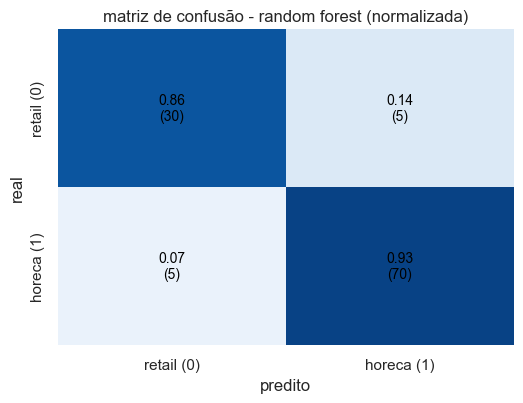

In [30]:
# questão 1
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

m_rf = report_metrics(y_test, y_pred_rf, "questão 1 - random forest")
plot_cm(y_test, y_pred_rf, title="matriz de confusão - random forest (normalizada)")

questão 2 - xgboost
accuracy     : 0.900
precision    : 0.921  (classe positiva = 1)
recall       : 0.933
f1           : 0.927
macro avg p  : 0.887 | macro avg r: 0.881 | macro avg f1: 0.884


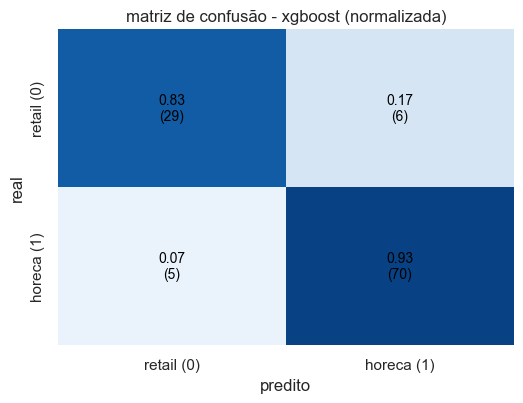

In [31]:
# questão 2
xgb = XGBClassifier(random_state=RANDOM_STATE, n_estimators=100, eval_metric="logloss")
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

m_xgb = report_metrics(y_test, y_pred_xgb, "questão 2 - xgboost")
plot_cm(y_test, y_pred_xgb, title="matriz de confusão - xgboost (normalizada)")

,modelo,accuracy,precision,recall,f1
0,random forest,0.909,0.933,0.933,0.933
1,xgboost,0.900,0.921,0.933,0.927


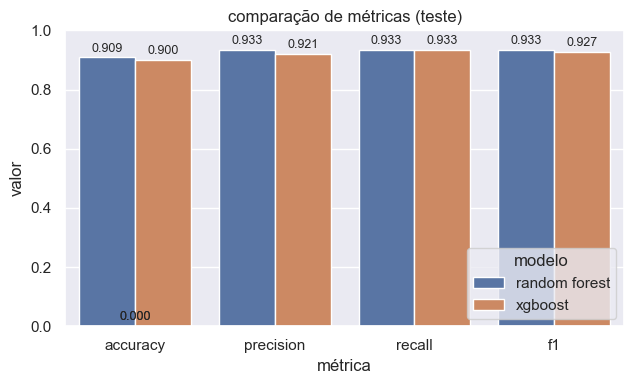

In [32]:
# questão 3
metrics = pd.DataFrame({
    "modelo": ["random forest", "xgboost"],
    "accuracy": [m_rf["accuracy"], m_xgb["accuracy"]],
    "precision": [m_rf["precision"], m_xgb["precision"]],
    "recall": [m_rf["recall"], m_xgb["recall"]],
    "f1": [m_rf["f1"], m_xgb["f1"]],
})
display(metrics.round(3))

metrics_melt = metrics.melt(id_vars="modelo", var_name="métrica", value_name="valor")
ax = sns.barplot(data=metrics_melt, x="métrica", y="valor", hue="modelo")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, xytext=(0,2), textcoords='offset points')
plt.ylim(0,1)
plt.title("comparação de métricas (teste)")
plt.tight_layout()
plt.show()

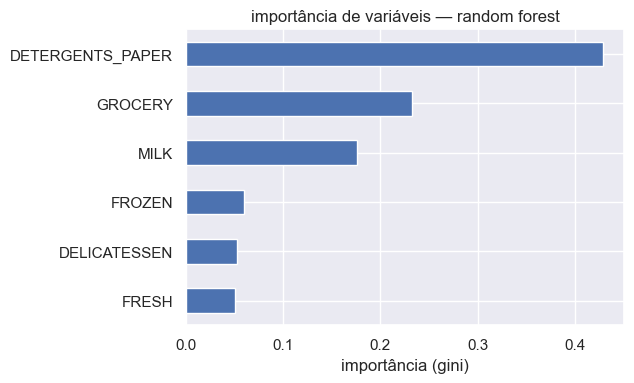

In [33]:
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
imp.plot(kind="barh")
plt.title("importância de variáveis — random forest")
plt.xlabel("importância (gini)")
plt.tight_layout()
plt.show()

**questão 3 — justificativa**

os dois modelos tiveram desempenho muito parecido, com f1 em torno de 0.93. o random forest apresentou accuracy = 0.909 e f1 = 0.933, enquanto o xgboost ficou com accuracy = 0.900 e f1 = 0.927. olhando a matriz de confusão, o random forest classificou um pouco melhor a classe 0 (retail), reduzindo a taxa de erro nessa categoria. como não há uma diferença expressiva em recall (ambos ≈0.933), a escolha recai sobre o random forest por ser mais simples de treinar, menos sensível a parametrização e ainda trazer interpretabilidade via importância de variáveis. portanto, entre os dois, eu ficaria com o random forest como modelo final.